In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import random

In [ ]:
def calculate_average_energy(test_data, predicted_spins):
    energies = np.array([-spin @ J @ spin for J, spin in zip(test_data, predicted_spins)])
    mean_energy = np.mean(energies)
    return mean_energy, energies

In [ ]:
def calculate_average_energy(test_data, predicted_spins):
    energies = np.array([-spin @ J @ spin for J, spin in zip(test_data, predicted_spins)])
    mean_energy = np.mean(energies)
    return mean_energy, energies
class GTDIsingModel:
    def __init__(self, matrix, temp=1.0, alpha=0.1, beta=0.01, gamma=0.9, epsilon=0.1, seed=None):
        self.matrix = matrix
        self.n = matrix.shape[0]
        self.temp = temp
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.epsilon = epsilon

        # Локальный генератор случайных чисел
        self.rng = np.random.RandomState(seed)
        self.random = random.Random(seed)

        # Веса для линейной аппроксимации Q-функции
        self.weights = self.rng.randn(2 * self.n + 1) * 0.01  # ✅ Контролируется
        self.secondary_weights = np.zeros(2 * self.n + 1)

        self.feature_history = []

    def get_features(self, spins, site, action):
        features = np.zeros(2 * self.n + 1)
        features[:self.n] = spins
        features[self.n + site] = 1
        features[-1] = action
        return features

    def get_q_value(self, spins, site, action):
        features = self.get_features(spins, site, action)
        return np.dot(features, self.weights)

    def delta_e(self, spins, site):
        k = site
        return 2 * spins[k] * (self.matrix[k, :] @ spins + self.matrix[:, k] @ spins - self.matrix[k, k] * spins[k])

    def calc_energy(self, spins):
        return -spins.T @ self.matrix @ spins

    def choose_action(self, spins, site, episode):
        epsilon = self.epsilon * (0.1 + 0.9 * np.exp(-episode / 500))

        if self.random.random() < epsilon:  # ✅ Контролируется
            delta_energy = self.delta_e(spins, site)
            if delta_energy < 0:
                return 1
            else:
                return 1 if self.random.random() < np.exp(-delta_energy / self.temp) else 0  # ✅ Контролируется
        else:
            q_value_0 = self.get_q_value(spins, site, 0)
            q_value_1 = self.get_q_value(spins, site, 1)
            return 0 if q_value_0 > q_value_1 else 1

    def calculate_reward(self, old_energy, new_energy, spins, best_energy):
        energy_diff = old_energy - new_energy
        reward = energy_diff
        if new_energy < best_energy:
            reward += abs(energy_diff) * 2
        return reward

    def update_gtd2(self, current_features, action, reward, next_features, next_action, r_alpha, r_beta):
        current_q = np.dot(current_features, self.weights)
        next_q = np.dot(next_features, self.weights)
        td_error = reward + self.gamma * next_q - current_q

        self.weights += r_alpha * (td_error * current_features -
                                 self.gamma * (1 - r_alpha * np.dot(current_features, current_features)) *
                                 next_features * np.dot(current_features, self.secondary_weights))

        self.secondary_weights += r_beta * (td_error - np.dot(current_features, self.secondary_weights)) * current_features

    def train(self, episodes=1000, steps_per_episode=100):
        best_energy = float('inf')
        best_spins = None
        n_best_energy = 0

        for episode in range(episodes):
            spins = 2 * self.rng.randint(2, size=self.n) - 1  # ✅ Контролируется
            current_energy = self.calc_energy(spins)
            print(f"Episode {episode}, Best energy: {best_energy}")

            if n_best_energy > 350:
                break

            if current_energy < best_energy:
                best_energy = current_energy
                best_spins = spins.copy()
                n_best_energy = 0
            else:
                n_best_energy += 1

            for step in range(steps_per_episode):
                site = self.rng.randint(0, self.n)  # ✅ Контролируется
                action = self.choose_action(spins, site, episode)
                r_alpha = self.alpha / (1 + episode/1000)
                r_beta = self.beta / (1 + episode/1000)

                current_features = self.get_features(spins, site, action)

                if action == 1:
                    new_e = self.delta_e(spins, site)

                    if new_e <= 0 or np.exp(-new_e / self.temp) > self.random.random():  # ✅ Контролируется
                        new_spins = spins.copy()
                        new_spins[site] *= -1
                        new_energy = self.calc_energy(new_spins)
                        reward = self.calculate_reward(current_energy, new_energy, spins, best_energy)

                        next_site = self.rng.randint(0, self.n)  # ✅ Контролируется
                        next_action = self.choose_action(new_spins, next_site, episode)
                        next_features = self.get_features(new_spins, next_site, next_action)

                        self.update_gtd2(current_features, action, reward, next_features, next_action, r_alpha, r_beta)

                        spins = new_spins
                        current_energy = new_energy

                        if current_energy < best_energy:
                            best_energy = current_energy
                            best_spins = spins.copy()

                    else:
                        next_site = self.rng.randint(0, self.n)  # ✅ Контролируется
                        next_action = self.choose_action(spins, next_site, episode)
                        next_features = self.get_features(spins, next_site, next_action)
                        self.update_gtd2(current_features, action, -current_energy, next_features, next_action, r_alpha, r_beta)

                else:
                    next_site = self.rng.randint(0, self.n)  # ✅ Контролируется
                    next_action = self.choose_action(spins, next_site, episode)
                    next_features = self.get_features(spins, next_site, next_action)
                    self.update_gtd2(current_features, action, -current_energy, next_features, next_action, r_alpha, r_beta)

        return best_energy, best_spins

In [4]:
test_matrices = np.load("test_matrices (1).npy")

In [5]:
import random
import numpy as np
import torch
import os

# Полная установка детерминизма
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Проверка
print("Random check:", random.random())
print("Numpy check:", np.random.rand())
print("Torch check:", torch.rand(1).item())

Random check: 0.6394267984578837
Numpy check: 0.3745401188473625
Torch check: 0.8822692632675171


In [ ]:
import pandas as pd
import os

optimal_spins = []
min_energies = []

# Создаем папку для результатов
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

for i, matrix in enumerate(test_matrices):
    model = GTDIsingModel(matrix, temp=0.8, alpha=0.02, beta=0.05, gamma=0.65, epsilon=0.91, seed=SEED)
    energy, spins = model.train(episodes=5000, steps_per_episode=5000)
    optimal_spins.append(spins)
    min_energies.append(energy)
    print(f"Matrix {i+1}: Minimal energy = {energy:.2f}")

    # Сохраняем чекпоинт каждые 40 матриц
    if (i + 1) % 20 == 0:
        # Сохраняем спин-конфигурации в нужном формате
        spins_df = pd.DataFrame(optimal_spins, columns=range(1, 201))
        energies_df = pd.DataFrame({'min_energy': min_energies})

        checkpoint_filename = f"{results_dir}/optimal_spins_checkpoint_{i-38}-{i+1}.csv"
        energies_filename = f"{results_dir}/energies_checkpoint_{i-38}-{i+1}.csv"

        spins_df.to_csv(checkpoint_filename, index=False)
        energies_df.to_csv(energies_filename, index=False)

        print(f"Checkpoint saved: {checkpoint_filename}")
        print(f"Energies saved: {energies_filename}")

# Сохраняем полные результаты
spins_df = pd.DataFrame(optimal_spins, columns=range(1, 201))
energies_df = pd.DataFrame({'min_energy': min_energies})

full_spins_filename = f"{results_dir}/optimal_spins_full.csv"
full_energies_filename = f"{results_dir}/energies_full.csv"

spins_df.to_csv(full_spins_filename, index=False)
energies_df.to_csv(full_energies_filename, index=False)

print(f"Full spins saved: {full_spins_filename}")
print(f"Full energies saved: {full_energies_filename}")

mean_energy, all_energies = calculate_average_energy(test_matrices, optimal_spins)
print(f"Average energy: {mean_energy:.4f}")

# Сохраняем среднюю энергию
summary_df = pd.DataFrame({'average_energy': [mean_energy]})
summary_df.to_csv(f"{results_dir}/summary.csv", index=False)

Episode 0, Best energy: inf


/tmp/ipython-input-739782389.py:65: RuntimeWarning: overflow encountered in subtract
  self.weights += r_alpha * (td_error * current_features -
/tmp/ipython-input-739782389.py:63: RuntimeWarning: invalid value encountered in scalar subtract
  td_error = reward + self.gamma * next_q - current_q
/tmp/ipython-input-739782389.py:66: RuntimeWarning: invalid value encountered in multiply
  self.gamma * (1 - r_alpha * np.dot(current_features, current_features)) *


Episode 1, Best energy: -3248
Episode 2, Best energy: -3248
Episode 3, Best energy: -3248
Episode 4, Best energy: -3284
Episode 5, Best energy: -3284
Episode 6, Best energy: -3284
Episode 7, Best energy: -3284
Episode 8, Best energy: -3284
Episode 9, Best energy: -3284
Episode 10, Best energy: -3284
Episode 11, Best energy: -3284
Episode 12, Best energy: -3284
Episode 13, Best energy: -3328
Episode 14, Best energy: -3328
Episode 15, Best energy: -3328
Episode 16, Best energy: -3328
Episode 17, Best energy: -3328
Episode 18, Best energy: -3328
Episode 19, Best energy: -3328
Episode 20, Best energy: -3328
Episode 21, Best energy: -3328
Episode 22, Best energy: -3328
Episode 23, Best energy: -3328
Episode 24, Best energy: -3328
Episode 25, Best energy: -3328
Episode 26, Best energy: -3328
Episode 27, Best energy: -3328
Episode 28, Best energy: -3328
Episode 29, Best energy: -3328
Episode 30, Best energy: -3328
Episode 31, Best energy: -3328
Episode 32, Best energy: -3332
Episode 33, Best 

/tmp/ipython-input-739782389.py:66: RuntimeWarning: overflow encountered in multiply
  self.gamma * (1 - r_alpha * np.dot(current_features, current_features)) *


Episode 1, Best energy: -3230
Episode 2, Best energy: -3230
Episode 3, Best energy: -3230
Episode 4, Best energy: -3270
Episode 5, Best energy: -3270
Episode 6, Best energy: -3270
Episode 7, Best energy: -3270
Episode 8, Best energy: -3270
Episode 9, Best energy: -3298
Episode 10, Best energy: -3346
Episode 11, Best energy: -3346
Episode 12, Best energy: -3346
Episode 13, Best energy: -3346
Episode 14, Best energy: -3346
Episode 15, Best energy: -3346
Episode 16, Best energy: -3346
Episode 17, Best energy: -3346
Episode 18, Best energy: -3346
Episode 19, Best energy: -3346
Episode 20, Best energy: -3346
Episode 21, Best energy: -3346
Episode 22, Best energy: -3346
Episode 23, Best energy: -3346
Episode 24, Best energy: -3346
Episode 25, Best energy: -3346
Episode 26, Best energy: -3346
Episode 27, Best energy: -3346
Episode 28, Best energy: -3346
Episode 29, Best energy: -3346
Episode 30, Best energy: -3414
Episode 31, Best energy: -3414
Episode 32, Best energy: -3414
Episode 33, Best 

/tmp/ipython-input-739782389.py:69: RuntimeWarning: invalid value encountered in multiply
  self.secondary_weights += r_beta * (td_error - np.dot(current_features, self.secondary_weights)) * current_features


Выходные данные были обрезаны до нескольких последних строк (5000).
Episode 289, Best energy: -3416
Episode 290, Best energy: -3416
Episode 291, Best energy: -3416
Episode 292, Best energy: -3416
Episode 293, Best energy: -3416
Episode 294, Best energy: -3416
Episode 295, Best energy: -3416
Episode 296, Best energy: -3416
Episode 297, Best energy: -3416
Episode 298, Best energy: -3416
Episode 299, Best energy: -3416
Episode 300, Best energy: -3416
Episode 301, Best energy: -3416
Episode 302, Best energy: -3416
Episode 303, Best energy: -3416
Episode 304, Best energy: -3416
Episode 305, Best energy: -3416
Episode 306, Best energy: -3416
Episode 307, Best energy: -3416
Episode 308, Best energy: -3416
Episode 309, Best energy: -3416
Episode 310, Best energy: -3416
Episode 311, Best energy: -3416
Episode 312, Best energy: -3416
Episode 313, Best energy: -3416
Episode 314, Best energy: -3416
Episode 315, Best energy: -3416
Episode 316, Best energy: -3416
Episode 317, Best energy: -3416
Epis

In [ ]:
optimal_spins = []
min_energies = []
for i, matrix in enumerate(test_matrices):
    model = GTDIsingModel(matrix, temp=1.1, alpha=0.15, beta=0.005, gamma=0.65, epsilon=0.8)
    energy, spins = model.train(episodes=5000, steps_per_episode=5000)
    optimal_spins.append(spins)
    min_energies.append(energy)
    print(f"Matrix {i+1}: Minimal energy = {energy:.2f}")

mean_energy, all_energies = calculate_average_energy(test_matrices, optimal_spins)
print(f"Average energy: {mean_energy:.4f}")

In [ ]:
mean_energy, all_energies = calculate_average_energy(test_matrices, optimal_spins)
print(f"Средняя энергия на сайте: {mean_energy /2:.4f}")

In [ ]:
df = pd.DataFrame(optimal_spins, columns=range(1, 201))
df.to_csv('optimal_spins.csv', index=False)

**Основные пояснения:**
1) В чём преимущества метода GTD для задачи подбора спинов для модели Изинга?
- Хорошая сходимость при линейной аппроксимации Q-функции
- Двойная система весов для стабильности (обновляются два набора параметров: один для оценки, другой для коррекции градиента)
- Устойчивость к зашумленным данным и несовпадению распределений.

Мы использовали GTD2 (это чуть улучшенная версия GTD (GTD минимизирует функцию ошибки, связанной с TD, с помощью градиентного подхода, но обновления параметров происходят в два этапа с двумя векторами весов), в которой обновления параметров организованы иначе и с некоторыми математическими усовершенствованиями для более стабильной и сходимой работы. GTD2 использует другую форму градиентного шага, что делает данный алгоритм более устойчивым.), она обеспечивает лучшую сходимость и более устойчиво работает на практике (проверено экспериментально), особенно с линейной аппроксимацией Q-функции, которая как раз у нас и есть.

https://arxiv.org/abs/2209.04624 - про методы GTD, GTD2 и другие

2) В чём преимущества метода GTD2 по сравнению с нашим прошлым решением (табличным Q-learning)?
- Решена проблема размерности (мы не строим таблицу, в этом случае количество состояний = 2^n. В GTD мы функцию линейно аппроксимируем (признаков намного меньше): self.weights = np.random.randn(self.n + 1) * 0.01
- Есть обобщение: обучение на одном состоянии улучшает предсказания для похожих состояний, а в табличном Q-learning похожие конфигурации спинов обучаются независимо, тем самым данные используются неэффективно
- Эффективность: меньшие затраты памяти (таблица занимает много места в отличие от n+1 параметров)
- Стабильность: практика показала, что GTD быстрее сходится к лучшему значению и стабильнее в обучении

3) Вы могли заметить, что в функциях choose_action, get_q_value и get_features нет ссылки на конкретный спин. Это от того, что мы анализируем q-функцию не на определенном спине при определенном состоянии, а обобщённо для всей системы (выгодно в данном состоянии переворачивать рандомный спин или нет). Данное архитектурное решение позволяет уменьшить пространство состояний (с n*2^n на 2^n - упрощает и ускоряет обучение), а также обобщает политику (агент учит "глобальное" качество состояния системы: в этой конфигурации в целом выгодно/не выгодно переворачивать спин).
Кроме того, мы пробовали решение с указанием рандомного спина, но код дольше обучался и была хуже сходимость.

4) Краткая аргументация выбора данных значений гиперпараметров:
- temp=1.1 - хотели иссоедование побольше :)
планировали сделать температуру тоже затухающей, ноо и без неё всё отлично было
- alpha=0.1, beta=0.005 - это скорости обучения для основных и вспомогательных весов соответственно (для основных весов - агрессивное обучение стратегии, но там достаточно большое значение для быстрой сходимости. Для вспомогательных - медленная коррекция смещения оценок, стабилизация основного обучения)
- gamma=0.6 - фактор дисконтирования. Агент видит достаточно далеко, чтобы находить хорошие паттерны, но не настолько далеко, чтобы запутаться в шуме. Обеспечивает быструю сходимость без застревания в локальных минимумах
- epsilon=0.8 - экспериментально выяснилось, что так соблюдается баланс exploration vs exploitation
- n_best_energy = 350 - экспериментально выяснилось, что при этом значении хорошо предсказываются спины


Схема нашего метода:

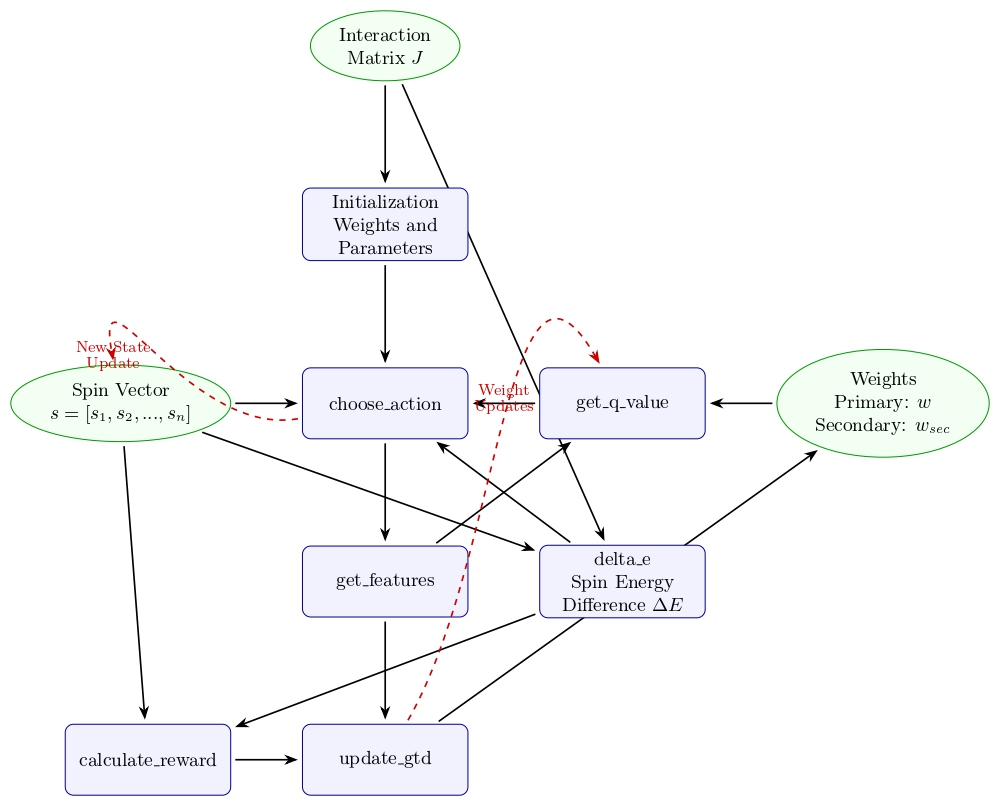